# How APALD Works

The following notebook is an explanation of the paknnld clustering algorithm. The foundational idea of partitioned local depth (PALD) comes from a 2022 paper (https://www.pnas.org/doi/10.1073/pnas.2003634119).

To make significant speed improvements that make the idea usable on larger datasets, we will suppose that clustering is primarily a local problem. With this in mind the approximate pald (APALD) algorithm can be described.

## Step 0: Setup

In [ ]:
%pip install matplotlib seaborn igraph

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data

%matplotlib inline
sns.set_context("poster")
sns.set_style("white")
sns.set_color_codes()
plot_kwds = {"alpha": 0.5, "s": 80, "linewidths": 0}

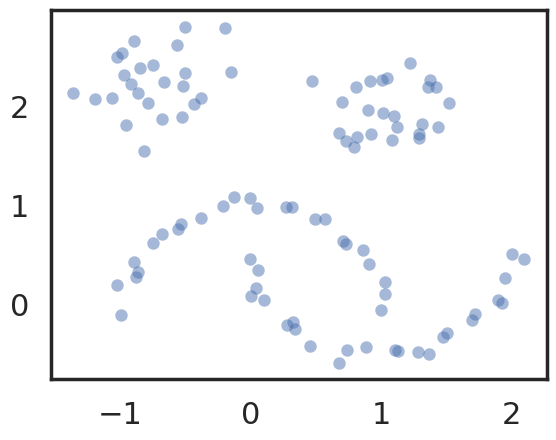

In [2]:
moons, _ = data.make_moons(n_samples=50, noise=0.05, random_state=123)
blobs, _ = data.make_blobs(
    n_samples=50,
    centers=[(-0.75, 2.25), (1.0, 2.0)],
    cluster_std=0.25,
    random_state=123,
)
test_data = np.vstack([moons, blobs])
plt.scatter(test_data.T[0], test_data.T[1], color="b", **plot_kwds)

## Step 1 Gets each points k nearest neighbors

Since we have decreed that clustering is local, we should only need to look at some nearest neighbors of each point to get a sense of it's clustering. How local is sufficiently local is a user parameter set by `n_neighbors`

In [3]:
import pynndescent

index = pynndescent.NNDescent(test_data, metric="euclidean", n_neighbors=10)
knn = index.neighbor_graph[0]
knn_dist = index.neighbor_graph[1]

Lets take a look at an example point

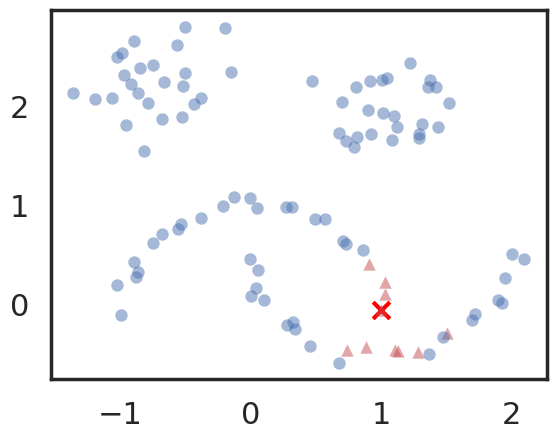

In [4]:
x = 5
fig, ax = plt.subplots()
ax.scatter(test_data[x, 0], test_data[x, 1], marker="x", color="red")

nearest_neighbors = knn[5]
ax.scatter(
    test_data[nearest_neighbors, 0],
    test_data[nearest_neighbors, 1],
    marker="^",
    color="r",
    **plot_kwds
)

not_nearest_neighbors = np.ones(test_data.shape[0], bool)
not_nearest_neighbors[nearest_neighbors] = False

ax.scatter(
    test_data[not_nearest_neighbors, 0],
    test_data[not_nearest_neighbors, 1],
    marker="o",
    color="b",
    **plot_kwds
)

If you look closely there is a circle under that x. For our purpose, a points nearest neighbor is always itself.

## Step 2: Create the Cohesion Matrix

From the previously mentioned paper, cohesion is a measure of similarity from the perspective of other points. Since we are working locally, we will consider the cohesion to each of it's k nearest neighbors. Additionally, since we already have the nearest neighbors computed, lets use the union of nearest neighbor sets instead of local focus.

For each nearest neighbor y, the strength of cohesion from y to x is the probability y is closer to x than a point chosen uniformly at random from the union of x and y's nearest neighbors.

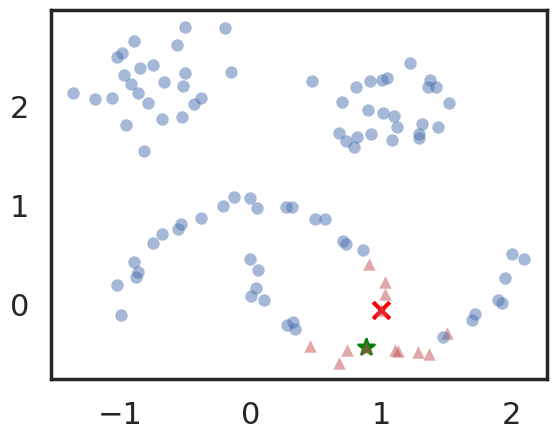

In [5]:
y = knn[x][3]

fig, ax = plt.subplots()
ax.scatter(test_data[x, 0], test_data[x, 1], marker="x", color="red")
ax.scatter(test_data[y, 0], test_data[y, 1], marker="*", color="green")

local_focus = np.zeros(test_data.shape[0], dtype="bool")
local_focus[np.union1d(knn[x], knn[y])] = True
ax.scatter(
    test_data[local_focus, 0],
    test_data[local_focus, 1],
    marker="^",
    color="r",
    **plot_kwds
)

not_focus = (1 - local_focus).astype("bool")
ax.scatter(
    test_data[not_focus, 0], test_data[not_focus, 1], marker="o", color="b", **plot_kwds
)

The cohesion from the green star y to x is the probability that, when choosing another point z uniformly from the red triangles, the y is close to the x than z is to x.

## Step 3: Make a weighted graph

From this cohesion matrix, we can make a graph where edge weights measure how similar the points are. We consider it an unweighted graph using the minimum cohesion. Finally, since there are normally lots of low weight edges, we drop the bottom 25% to make step 4 faster.

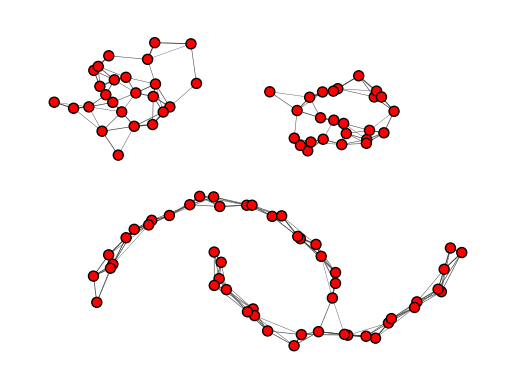

In [13]:
import pald
import igraph

# Build the Cohesion Matrix
paknnld = pald.PAKNNLD(n_neighbors=10, metric="euclidean", thresh=0.25)
paknnld.fit(test_data)

# Use the minimum cohesion and filter small edges.
symmetric_cohesion = paknnld.cohesion_.minimum(paknnld.cohesion_.transpose())
symmetric_cohesion.data = np.where(
        symmetric_cohesion.data>np.quantile(symmetric_cohesion.data, 0.25),
        symmetric_cohesion.data,
        0,
    )
symmetric_cohesion.setdiag(0)

# Plot the graph
g = igraph.Graph.Weighted_Adjacency(symmetric_cohesion, mode="undirected")
fig, ax = plt.subplots()
style = {"vertex_size": 10, "edge_width": g.es["weight"]}
igraph.plot(g, target=ax, layout=test_data.tolist(), **style)

## Step 4: Run Clustering on this Graph

We are using leiden clustering for 5 iterations, maximising for VertexModularity. This is the least confident part of the algorithm and other suggestions are welcome. (I have tried playing with CBM + resolution to get mulitple resolutions).

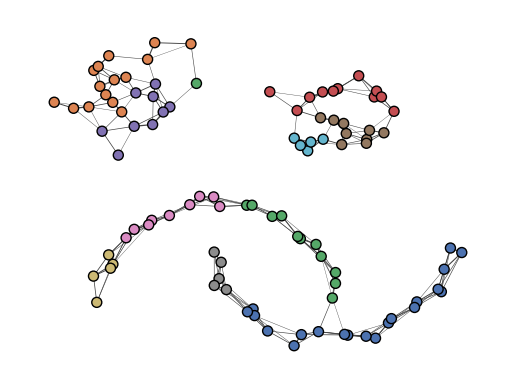

In [15]:
predict = paknnld.labels_

fig, ax = plt.subplots()
palette = sns.color_palette("deep", np.unique(predict).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in predict]
style = {
    "vertex_size": 10,
    "vertex_color": colors,
    "edge_width": g.es["weight"],
}
igraph.plot(g, target=ax, layout=test_data.tolist(), **style)

Seems to be doing alright. It's given us a refinement of the "true" partition.